In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from string_to_embedding import string_to_embedding, super_to_embedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
class Model(nn.Module):
    def __init__(self, imgchannels=1, fdim=8, zdim=32, mdim=1024, kern=3, imgshape=(3,3), stride=1, pad=1):
        
        super(Model, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 8 convolutional features, with a square kernel size of 2
        self.conv1 = nn.Conv2d(imgchannels, fdim, kern, stride, pad) # (1, 8, 3, 1)

        # Second 2D convolutional layer, taking in the 8 input layers,
        # outputting 32 convolutional features, with a square kernel size of 2
        self.conv2 = nn.Conv2d(fdim, zdim, kern, stride, pad) # (8, 32, 3, 1, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        
        ldim = zdim*imgshape[0]*imgshape[1]
        self.ldim = ldim

        # First fully connected layer
        self.fc1 = nn.Linear(ldim, mdim) #add a middle linear layer, with size 
        
        #outdim = (imgshape[0]*imgshape[1])**2*3+imgshape[0]*imgshape[1]*2
        outdim = (imgshape[0]*imgshape[1])**2*3
        self.fc2 = nn.Linear(mdim, outdim)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(x)
        #print(x.shape)
        
        #x = self.dropout1(x)
        x = x.view(-1, self.ldim)
        #print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        #print(x.shape)
        #x = self.dropout2(x)
        x = self.fc2(x)
        #print(x.shape)
        
        x = F.relu(x)
        x = x.bool()
        
        return x
model = Model().to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=243, bias=True)
)
cpu


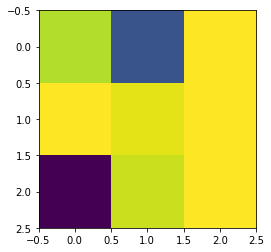

In [3]:
rand_smap = generate_gaussian(10, 3, 3)
plt.imshow(rand_smap)

In [4]:
rand_smap = torch.Tensor(rand_smap.reshape(1, 1, rand_smap.shape[0], rand_smap.shape[1]))
print(rand_smap)


tensor([[[[ 8.8454,  2.6071, 10.0000],
          [10.0000,  9.5903, 10.0000],
          [ 0.0000,  9.2179, 10.0000]]]])


In [5]:
result = model(rand_smap)
print(result)
print(result.shape)


tensor([[ True,  True, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False,  True, False, False,
          True,  True,  True, False,  True, False, False, False, False,  True,
         False, False,  True,  True,  True,  True, False,  True, False,  True,
          True,  True, False, False,  True,  True, False, False, False, False,
         False,  True,  True, False,  True, False, False,  True,  True, False,
          True, False, False, False, False, False,  True, False, False, False,
         False,  True,  True,  True,  True,  True,  True, False, False,  True,
         False,  True, False, False, False,  True, False, False,  True, False,
          True,  True,  True, False,  True, False, False, False, False, False,
          True, False,  True, False, False, False,  True,  True, False,  True,
         False, False,  True,  True, False,  True,  True,  True, False, False,
         False, False,  True, False, False, False,  

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


(13, 25, 60, 17, 1, 0, 1.0)
2022-11-11 14:47:07,483 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Unsupported Ngspice version 37


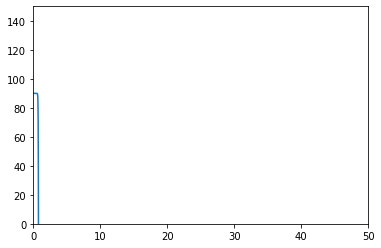

In [6]:
## convert output to embedding using SolarModule object
model.eval()
with torch.no_grad():
    out_data = model(rand_smap)
    #out_data = out_data.type(torch.bool)
    #print(out_data)
    
    embedding = out_data.reshape(3, 3, 3, 3, 3).cpu().numpy()
    
moduleobj = SolarModule(3,3)
moduleobj.embedding = embedding
# Fix (0,0) and (2,2) to be ground and positive
moduleobj.connect_to_ground(0,0)
moduleobj.connect_to_pos(2,2)

print(moduleobj.filter_embedding())
moduleobj.make_netlist()
moduleobj.simulate()
moduleobj.plot_netlist()

In [7]:
""" Initialize Hyperparameters """
#10,000 iterations, batching of 32

#1e-3 learning rate

# vary each training parameter individually, run multiple experiments. Checkpoint each model, filename w/ parameters

batch_size = 32 # 32-64 is advisable
learning_rate = 1e-4 # sensitivity of gradient descent
num_epochs = 10 # iterations over entire dataset 


In [5]:
""" Generate 3x3 Shading Maps"""
filename = '3x3shading_maps.csv'
maps = []
for x in range(0, 1000):
    rand_smap = generate_gaussian(10, 3, 3)
    maps.append(rand_smap)

maps = pd.Series(maps, name='Shading Maps')
maps.to_csv(filename)

In [9]:
""" Load 3x3 Shading Maps"""
read_in = pd.read_csv('3x3shading_maps.csv')
    
def convert_to_array(string):
    a = np.matrix(string).reshape(3, 3)
    a = np.array(a)
    return a
shading_series = [convert_to_array(s) for s in read_in['Shading Maps']]
data = [torch.Tensor(s.reshape(1,s.shape[0],s.shape[1])) for s in shading_series]
#dataset = CustomDataset(data, list(range(len(data))))
#print(dataset)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
#print(shading_series[234])

In [10]:
model = Model().to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=243, bias=True)
)
cpu


In [ ]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# iterate over epochs
loss_graph = []
for epoch in range(num_epochs):
    
    # iterate over training dataset by batch
    for i, data in enumerate(train_loader, 0):
        
        shading_maps = data
        shading_maps = shading_maps.to(device)

        loss_list = []
        for j in range(batch_size):
            
            embedding = model(shading_maps[j,...])[-1].cpu().numpy()
            embedding = embedding.reshape(3, 3, 3, 3, 3)
            
            moduleobj = SolarModule(3, 3)
            moduleobj.embedding = embedding
            
            moduleobj.connect_to_ground(0,0)
            moduleobj.connect_to_pos(2,2)
            print(moduleobj.filter_embedding())
            moduleobj.make_netlist()
            try:
                moduleobj.simulate()
            except:
                moduleobj.MPP = 0
            
            loss_list.append((60 - moduleobj.MPP)/100)
            
        loss_ = np.mean(loss_list)
        loss = torch.tensor(loss_, requires_grad=True)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('Epoch {}: Loss {}'.format(epoch, loss))
    loss_graph.append(loss)
    
# create validation/evaluation batch of 10 or so shading maps, calculate the power from that
# visualise embeddings or circuit diagram against shading map

# use embeddings generated by superstrings for supervised approach. 
# pre-train on training_data.csv
# binary cross entropy between model and training data

# sort training_data.csv by performance (power)
# train same model by binary cross entropy
# use entire dataset, then use higher performing subset, then a subset of that, etc. 
# label = embedding


(11, 47, 65, 17, 1, 0, 1.0)
(11, 42, 63, 17, 1, 0, 1.0)
(11, 43, 64, 17, 1, 0, 1.0)
(9, 37, 62, 17, 1, 0, 1.0)
(12, 43, 65, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 39, 65, 17, 1, 0, 1.0)


/Users/mlima/Documents/GitHub/reconfig-bipv/solar_module.py:297: RuntimeWarning: invalid value encountered in double_scalars
  self.FF = self.MPP/(self.VOC * self.ISC)


(10, 35, 63, 17, 1, 0, 1.0)
(11, 42, 64, 17, 1, 0, 1.0)
(10, 41, 64, 17, 1, 0, 1.0)
(10, 43, 66, 17, 1, 0, 1.0)
(11, 36, 67, 17, 1, 0, 1.0)
(10, 40, 66, 17, 1, 0, 1.0)
(9, 41, 62, 17, 1, 0, 1.0)
(10, 35, 63, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 42, 61, 17, 1, 0, 1.0)
(8, 41, 64, 17, 1, 0, 1.0)
(10, 42, 60, 17, 1, 0, 1.0)
(11, 41, 66, 17, 1, 0, 1.0)
(12, 40, 63, 17, 1, 0, 1.0)
(11, 44, 66, 17, 1, 0, 1.0)
(11, 38, 64, 17, 1, 0, 1.0)
(10, 44, 64, 17, 1, 0, 1.0)
(12, 46, 68, 17, 1, 0, 1.0)
(11, 38, 64, 17, 1, 0, 1.0)
(12, 41, 65, 17, 1, 0, 1.0)
(11, 36, 62, 17, 1, 0, 1.0)
(10, 45, 65, 17, 1, 0, 1.0)
(13, 42, 65, 17, 1, 0, 1.0)
(9, 39, 59, 17, 1, 0, 1.0)
(10, 42, 60, 17, 1, 0, 1.0)
(10, 42, 62, 17, 1, 0, 1.0)
(9, 43, 65, 17, 1, 0, 1.0)
(10, 40, 65, 17, 1, 0, 1.0)
(10, 39, 62, 17, 1, 0, 1.0)
(9, 39, 65, 17, 1, 0, 1.0)
(8, 39, 63, 17, 1, 0, 1.0)
(10, 40, 61, 17, 1, 0, 1.0)
(9, 41, 63, 17, 1, 0, 1.0)
(10, 36, 68, 17, 1, 0, 1.0)
(10, 37, 64, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)

2022-11-11 14:47:53,244 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:47:53,245 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9944E-03 Warning: singular matrix:  check nodes xline2.t_load and xline2.t_load
2022-11-11 14:47:53,245 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:47:53,246 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9986E-03 Warning: singular matrix:  check nodes xline2.t_load and xline2.t_load
2022-11-11 14:47:53,247 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:47:53,248 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9996E-03 Warning: singular matrix:  check nodes xline2.t_load and xline2.t_load
2022-11-11 14:47:53,248 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - 

2022-11-11 14:47:57,771 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:47:57,771 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting dynamic gmin stepping
2022-11-11 14:47:57,772 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:47:57,772 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:47:57,773 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:47:57,774 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: One successful gmin step
2022-11-11 14:47:57,775 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin ste

(10, 41, 64, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 41, 63, 17, 1, 0, 1.0)
(10, 40, 61, 17, 1, 0, 1.0)
(10, 41, 62, 17, 1, 0, 1.0)
2022-11-11 14:47:58,108 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:47:58,108 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:47:58,109 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting dynamic gmin stepping
2022-11-11 14:47:58,109 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:47:58,110 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:47:58,110 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successfu

Exception ignored from cffi callback <function NgSpiceShared._send_stat at 0x144f52c10>:
Traceback (most recent call last):
  File "/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/PySpice/Spice/NgSpice/Shared.py", line 644, in _send_stat
    @staticmethod
KeyboardInterrupt: 


(11, 37, 63, 17, 1, 0, 1.0)
(10, 38, 65, 17, 1, 0, 1.0)
(12, 36, 68, 17, 1, 0, 1.0)
(10, 38, 64, 17, 1, 0, 1.0)
(9, 42, 60, 17, 1, 0, 1.0)
(10, 38, 62, 17, 1, 0, 1.0)
(9, 41, 60, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(11, 39, 62, 17, 1, 0, 1.0)
(9, 37, 63, 17, 1, 0, 1.0)
(12, 44, 65, 17, 1, 0, 1.0)
(8, 38, 62, 17, 1, 0, 1.0)
(9, 37, 64, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
(10, 43, 62, 17, 1, 0, 1.0)
(9, 39, 61, 17, 1, 0, 1.0)
(11, 44, 65, 17, 1, 0, 1.0)
(10, 42, 63, 17, 1, 0, 1.0)
(9, 43, 60, 17, 1, 0, 1.0)
(13, 41, 62, 17, 1, 0, 1.0)
(8, 43, 60, 17, 1, 0, 1.0)
(11, 42, 65, 17, 1, 0, 1.0)
(13, 39, 64, 17, 1, 0, 1.0)
(10, 38, 63, 17, 1, 0, 1.0)
(12, 39, 64, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(10, 34, 63, 17, 1, 0, 1.0)
(8, 43, 62, 17, 1, 0, 1.0)
(10, 44, 63, 17, 1, 0, 1.0)
(10, 42, 60, 17, 1, 0, 1.0)
(11, 37, 66, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 39, 64, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(12, 45, 63, 17, 1, 0, 1.0)
(11, 45, 64, 17, 1, 0, 1.0)
(1

2022-11-11 14:48:04,467 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9105E-03 Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:04,467 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:04,467 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9775E-03 Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:04,468 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:04,468 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9944E-03 Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:04,469 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:04,469 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Tr

(9, 40, 65, 17, 1, 0, 1.0)
(10, 40, 62, 17, 1, 0, 1.0)
(11, 41, 67, 17, 1, 0, 1.0)
(10, 39, 62, 17, 1, 0, 1.0)
(12, 40, 65, 17, 1, 0, 1.0)
(10, 43, 63, 17, 1, 0, 1.0)
(10, 44, 65, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(11, 44, 65, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 40, 66, 17, 1, 0, 1.0)
(12, 37, 66, 17, 1, 0, 1.0)
(10, 43, 62, 17, 1, 0, 1.0)
(11, 45, 67, 17, 1, 0, 1.0)
(10, 41, 62, 17, 1, 0, 1.0)
(11, 43, 62, 17, 1, 0, 1.0)
2022-11-11 14:48:08,785 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:08,786 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:08,786 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting dynamic gmin stepping
2022-11-11 14:48:08,786 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 

2022-11-11 14:48:11,382 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.6466E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:11,382 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:11,382 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9105E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:11,383 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:11,383 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9775E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:11,384 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:11,384 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Tr

2022-11-11 14:48:12,267 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:12,268 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check nodes xline3.t_load and xline3.t_load
2022-11-11 14:48:12,268 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:12,269 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   8.6596E-03 Warning: singular matrix:  check nodes xline3.t_load and xline3.t_load
2022-11-11 14:48:12,269 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:12,269 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.6466E-03 Note: One successful gmin step
2022-11-11 14:48:12,270 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.1398E-03 Warning: singul

(11, 44, 63, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
(10, 41, 60, 17, 1, 0, 1.0)
(10, 43, 61, 17, 1, 0, 1.0)
(10, 40, 63, 17, 1, 0, 1.0)
(10, 43, 66, 17, 1, 0, 1.0)
(9, 41, 63, 17, 1, 0, 1.0)
(9, 40, 62, 17, 1, 0, 1.0)
(9, 41, 63, 17, 1, 0, 1.0)
(11, 42, 67, 17, 1, 0, 1.0)
(10, 43, 63, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 40, 62, 17, 1, 0, 1.0)
(10, 41, 65, 17, 1, 0, 1.0)
(8, 43, 61, 17, 1, 0, 1.0)
(10, 40, 62, 17, 1, 0, 1.0)
(10, 43, 60, 17, 1, 0, 1.0)
(10, 42, 65, 17, 1, 0, 1.0)
(11, 43, 64, 17, 1, 0, 1.0)
(11, 44, 66, 17, 1, 0, 1.0)
(9, 43, 64, 17, 1, 0, 1.0)
(15, 40, 66, 17, 1, 0, 1.0)
(10, 43, 64, 17, 1, 0, 1.0)
2022-11-11 14:48:14,824 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:14,825 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:14,825 - PySpice.Spice.NgSp

2022-11-11 14:48:14,856 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.0000% Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:14,856 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: source stepping failed
2022-11-11 14:48:14,857 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op started
2022-11-11 14:48:14,858 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op finished successfully
(11, 45, 64, 17, 1, 0, 1.0)
(9, 41, 61, 17, 1, 0, 1.0)
(11, 40, 65, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(11, 41, 62, 17, 1, 0, 1.0)
(10, 45, 61, 17, 1, 0, 1.0)
(10, 43, 62, 17, 1, 0, 1.0)
(10, 42, 61, 17, 1, 0, 1.0)
(10, 42, 63, 17, 1, 0, 1.0)
(10, 45, 61, 17, 1, 0, 1.0)
(13, 44, 63, 17, 1, 0, 1.0)
(11, 44, 66, 17, 1, 0, 1.0)
(9, 43, 63, 17, 1, 0, 1.0)
(7, 44, 64, 17, 1, 0, 1.0)
2022-11-11 14:48:15,278 - PySpice.Spice.NgSpice.Shared.NgSpiceSh

2022-11-11 14:48:15,325 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:48:15,325 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14:48:15,325 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:48:15,326 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:48:15,326 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gmin step
2022-11-11 14:48:15,326 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:48:15,327 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: One successful source step
2022-11-11 14:48:

2022-11-11 14:48:16,975 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Last gmin step failed
2022-11-11 14:48:16,976 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:16,976 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: True gmin stepping failed
2022-11-11 14:48:16,976 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting source stepping
2022-11-11 14:48:16,977 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.0000% Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:16,977 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-02 Note: One successful gmin step
2022-11-11 14:48:16,977 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11

2022-11-11 14:48:19,527 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:19,527 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check nodes xline2.t_load and xline2.t_load
2022-11-11 14:48:19,527 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:19,528 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   8.6596E-03 Warning: singular matrix:  check nodes xline2.t_load and xline2.t_load
2022-11-11 14:48:19,528 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:19,529 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.6466E-03 Warning: singular matrix:  check nodes xline2.t_load and xline2.t_load
2022-11-11 14:48:19,529 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - 

2022-11-11 14:48:21,089 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:48:21,089 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:48:21,090 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gmin step
2022-11-11 14:48:21,090 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:48:21,090 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:48:21,090 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:21,091 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Dynamic gmin stepping fa

(11, 41, 65, 17, 1, 0, 1.0)
(9, 41, 60, 17, 1, 0, 1.0)
(9, 44, 63, 17, 1, 0, 1.0)
(11, 40, 65, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(11, 41, 66, 17, 1, 0, 1.0)
(12, 44, 62, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 41, 63, 17, 1, 0, 1.0)
(11, 42, 65, 17, 1, 0, 1.0)
(12, 34, 67, 17, 1, 0, 1.0)
(10, 38, 61, 17, 1, 0, 1.0)
(9, 40, 62, 17, 1, 0, 1.0)
(10, 42, 67, 17, 1, 0, 1.0)
(10, 40, 66, 17, 1, 0, 1.0)
(9, 39, 67, 17, 1, 0, 1.0)
(8, 42, 62, 17, 1, 0, 1.0)
(10, 40, 62, 17, 1, 0, 1.0)
(9, 41, 60, 17, 1, 0, 1.0)
(8, 47, 62, 17, 1, 0, 1.0)
(11, 43, 66, 17, 1, 0, 1.0)
(9, 39, 64, 17, 1, 0, 1.0)
(9, 39, 59, 17, 1, 0, 1.0)
(9, 39, 61, 17, 1, 0, 1.0)
(8, 43, 62, 17, 1, 0, 1.0)
(14, 39, 64, 17, 1, 0, 1.0)
(12, 40, 65, 17, 1, 0, 1.0)
(10, 42, 62, 17, 1, 0, 1.0)
(10, 44, 61, 17, 1, 0, 1.0)
(9, 38, 63, 17, 1, 0, 1.0)
(12, 39, 64, 17, 1, 0, 1.0)
(9, 42, 61, 17, 1, 0, 1.0)
(13, 43, 61, 17, 1, 0, 1.0)
(12, 44, 64, 17, 1, 0, 1.0)
(11, 42, 66, 17, 1, 0, 1.0)
(10, 43, 64, 17, 1, 0, 1.0)
(8, 40

2022-11-11 14:48:25,469 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:25,470 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9996E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:25,470 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Last gmin step failed
2022-11-11 14:48:25,471 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:25,471 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: True gmin stepping failed
2022-11-11 14:48:25,472 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting source stepping
2022-11-11 14:48:25,473 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.0000% Warning: singular matrix:  check nodes xline1.t_load and xline

(10, 41, 62, 17, 1, 0, 1.0)
(12, 42, 65, 17, 1, 0, 1.0)
(10, 43, 66, 17, 1, 0, 1.0)
(13, 40, 62, 17, 1, 0, 1.0)
(10, 39, 61, 17, 1, 0, 1.0)
(12, 43, 63, 17, 1, 0, 1.0)
(11, 40, 64, 17, 1, 0, 1.0)
(10, 40, 65, 17, 1, 0, 1.0)
(11, 41, 66, 17, 1, 0, 1.0)
(10, 38, 66, 17, 1, 0, 1.0)
(11, 41, 62, 17, 1, 0, 1.0)
(13, 43, 61, 17, 1, 0, 1.0)
(11, 44, 66, 17, 1, 0, 1.0)
(10, 43, 66, 17, 1, 0, 1.0)
(11, 38, 60, 17, 1, 0, 1.0)
(11, 43, 62, 17, 1, 0, 1.0)
(10, 45, 62, 17, 1, 0, 1.0)
(9, 43, 64, 17, 1, 0, 1.0)
(10, 35, 61, 17, 1, 0, 1.0)
(13, 44, 63, 17, 1, 0, 1.0)
(9, 37, 62, 17, 1, 0, 1.0)
(13, 41, 63, 17, 1, 0, 1.0)
(11, 44, 66, 17, 1, 0, 1.0)
(11, 39, 64, 17, 1, 0, 1.0)
(10, 39, 65, 17, 1, 0, 1.0)
(11, 46, 65, 17, 1, 0, 1.0)
(12, 44, 66, 17, 1, 0, 1.0)
(11, 42, 62, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 38, 69, 17, 1, 0, 1.0)
(11, 39, 65, 17, 1, 0, 1.0)
(9, 37, 62, 17, 1, 0, 1.0)
(9, 39, 63, 17, 1, 0, 1.0)
(7, 43, 67, 17, 1, 0, 1.0)
(9, 40, 62, 17, 1, 0, 1.0)
(10, 40, 66, 17, 1, 0, 1.0

2022-11-11 14:48:36,212 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:36,212 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.6466E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:36,212 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:36,213 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9105E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:36,213 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:36,213 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9775E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:36,214 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - 

2022-11-11 14:48:37,898 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:48:37,898 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:48:37,898 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:37,899 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Dynamic gmin stepping failed
2022-11-11 14:48:37,899 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting true gmin stepping
2022-11-11 14:48:37,899 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:37,900 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
202

(13, 46, 67, 17, 1, 0, 1.0)
(10, 36, 63, 17, 1, 0, 1.0)
(11, 40, 61, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(11, 44, 61, 17, 1, 0, 1.0)
(9, 40, 62, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
(12, 45, 66, 17, 1, 0, 1.0)
(11, 33, 62, 17, 1, 0, 1.0)
(10, 43, 62, 17, 1, 0, 1.0)
(9, 43, 63, 17, 1, 0, 1.0)
(13, 45, 67, 17, 1, 0, 1.0)
(9, 45, 65, 17, 1, 0, 1.0)
(10, 42, 63, 17, 1, 0, 1.0)
(10, 39, 66, 17, 1, 0, 1.0)
(10, 44, 64, 17, 1, 0, 1.0)
(11, 38, 64, 17, 1, 0, 1.0)
(9, 41, 62, 17, 1, 0, 1.0)
(7, 43, 64, 17, 1, 0, 1.0)
(10, 40, 62, 17, 1, 0, 1.0)
(9, 38, 67, 17, 1, 0, 1.0)
(10, 37, 63, 17, 1, 0, 1.0)
(10, 37, 64, 17, 1, 0, 1.0)
(11, 45, 65, 17, 1, 0, 1.0)
(10, 42, 62, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 43, 62, 17, 1, 0, 1.0)
(12, 48, 67, 17, 1, 0, 1.0)
(17, 42, 62, 17, 1, 0, 1.0)
(10, 40, 61, 17, 1, 0, 1.0)
(13, 39, 66, 17, 1, 0, 1.0)
(12, 39, 67, 17, 1, 0, 1.0)
(13, 40, 63, 17, 1, 0, 1.0)
(11, 44, 64, 17, 1, 0, 1.0)
(10, 37, 64, 17, 1, 0, 1.0)

2022-11-11 14:48:41,187 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:48:41,188 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: One successful source step
2022-11-11 14:48:41,189 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.1000% Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:41,189 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.0000% Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:48:41,190 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: source stepping failed
2022-11-11 14:48:41,190 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op started
2022-11-11 14:48:41,192 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op finished successfully
(10

2022-11-11 14:48:42,407 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:48:42,407 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: One successful gmin step
2022-11-11 14:48:42,407 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:48:42,408 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14:48:42,408 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:48:42,408 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:48:42,409 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gm

2022-11-11 14:48:47,282 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:48:47,282 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:47,283 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Dynamic gmin stepping failed
2022-11-11 14:48:47,284 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting true gmin stepping
2022-11-11 14:48:47,284 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:48:47,285 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:48:47,286 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check n

(10, 40, 62, 17, 1, 0, 1.0)
(9, 39, 59, 17, 1, 0, 1.0)
(11, 39, 60, 17, 1, 0, 1.0)
(10, 45, 59, 17, 1, 0, 1.0)
(10, 44, 62, 17, 1, 0, 1.0)
(10, 39, 66, 17, 1, 0, 1.0)
(9, 43, 63, 17, 1, 0, 1.0)
(11, 40, 67, 17, 1, 0, 1.0)
(9, 43, 59, 17, 1, 0, 1.0)
(10, 36, 61, 17, 1, 0, 1.0)
(12, 38, 65, 17, 1, 0, 1.0)
(10, 45, 62, 17, 1, 0, 1.0)
(11, 40, 60, 17, 1, 0, 1.0)
(9, 43, 62, 17, 1, 0, 1.0)
(10, 41, 60, 17, 1, 0, 1.0)
(12, 42, 66, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 40, 64, 17, 1, 0, 1.0)
(11, 42, 64, 17, 1, 0, 1.0)
(8, 43, 63, 17, 1, 0, 1.0)
(9, 36, 65, 17, 1, 0, 1.0)
(12, 46, 63, 17, 1, 0, 1.0)
(9, 38, 67, 17, 1, 0, 1.0)
(10, 35, 61, 17, 1, 0, 1.0)
(11, 42, 62, 17, 1, 0, 1.0)
(11, 44, 66, 17, 1, 0, 1.0)
(10, 48, 66, 17, 1, 0, 1.0)
(8, 43, 66, 17, 1, 0, 1.0)
(14, 44, 67, 17, 1, 0, 1.0)
(12, 43, 63, 17, 1, 0, 1.0)
(13, 39, 67, 17, 1, 0, 1.0)
(11, 40, 64, 17, 1, 0, 1.0)
(13, 37, 63, 17, 1, 0, 1.0)
(13, 43, 61, 17, 1, 0, 1.0)
(10, 43, 60, 17, 1, 0, 1.0)
(10, 39, 62, 17, 1, 0, 1.0)
(

2022-11-11 14:48:57,600 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:48:57,600 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: One successful gmin step
2022-11-11 14:48:57,601 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:48:57,601 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14:48:57,601 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:48:57,602 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:48:57,602 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gm

(10, 41, 64, 17, 1, 0, 1.0)
(9, 40, 62, 17, 1, 0, 1.0)
(9, 41, 62, 17, 1, 0, 1.0)
(12, 43, 63, 17, 1, 0, 1.0)
(12, 44, 64, 17, 1, 0, 1.0)
(9, 44, 61, 17, 1, 0, 1.0)
(8, 39, 63, 17, 1, 0, 1.0)
(12, 46, 68, 17, 1, 0, 1.0)
(10, 43, 63, 17, 1, 0, 1.0)
(10, 43, 66, 17, 1, 0, 1.0)
(13, 42, 63, 17, 1, 0, 1.0)
(10, 38, 63, 17, 1, 0, 1.0)
(10, 44, 65, 17, 1, 0, 1.0)
(10, 42, 59, 17, 1, 0, 1.0)
(7, 44, 62, 17, 1, 0, 1.0)
(10, 41, 64, 17, 1, 0, 1.0)
(15, 43, 68, 17, 1, 0, 1.0)
(9, 45, 65, 17, 1, 0, 1.0)
(11, 34, 62, 17, 1, 0, 1.0)
(12, 44, 64, 17, 1, 0, 1.0)
(9, 43, 64, 17, 1, 0, 1.0)
(10, 42, 63, 17, 1, 0, 1.0)
(11, 39, 66, 17, 1, 0, 1.0)
(11, 45, 64, 17, 1, 0, 1.0)
(11, 40, 63, 17, 1, 0, 1.0)
(11, 42, 61, 17, 1, 0, 1.0)
(12, 43, 64, 17, 1, 0, 1.0)
(10, 37, 64, 17, 1, 0, 1.0)
(11, 40, 63, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(10, 41, 66, 17, 1, 0, 1.0)
(11, 40, 64, 17, 1, 0, 1.0)
(9, 40, 62, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
(10, 44, 64, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)


2022-11-11 14:49:00,275 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14:49:00,275 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:49:00,276 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:49:00,276 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gmin step
2022-11-11 14:49:00,277 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:00,277 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: One successful source step
2022-11-11 14:49:00,278 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.1000% Warning: singular matrix:  check nodes xline1

2022-11-11 14:49:01,443 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.0000% Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:49:01,444 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-02 Note: One successful gmin step
2022-11-11 14:49:01,444 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:49:01,445 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:49:01,445 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:49:01,446 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: One successful gmin step
2022-11-11 14:49:01,447 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying 

2022-11-11 14:49:04,842 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting true gmin stepping
2022-11-11 14:49:04,842 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:04,842 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:04,843 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:04,843 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:04,843 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   8.6596E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:04,843 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - 

2022-11-11 14:49:05,458 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:49:05,458 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14:49:05,458 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:49:05,459 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:49:05,459 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gmin step
2022-11-11 14:49:05,460 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:05,460 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gm

(11, 42, 62, 17, 1, 0, 1.0)
(11, 47, 65, 17, 1, 0, 1.0)
(12, 44, 65, 17, 1, 0, 1.0)
(12, 44, 62, 17, 1, 0, 1.0)
(10, 42, 66, 17, 1, 0, 1.0)
(12, 39, 62, 17, 1, 0, 1.0)
(11, 42, 63, 17, 1, 0, 1.0)
(7, 38, 65, 17, 1, 0, 1.0)
(8, 41, 65, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 37, 62, 17, 1, 0, 1.0)
(9, 42, 62, 17, 1, 0, 1.0)
(10, 42, 62, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 41, 61, 17, 1, 0, 1.0)
(9, 38, 65, 17, 1, 0, 1.0)
(10, 42, 63, 17, 1, 0, 1.0)
(10, 38, 69, 17, 1, 0, 1.0)
(10, 40, 64, 17, 1, 0, 1.0)
(8, 46, 68, 17, 1, 0, 1.0)
(8, 41, 62, 17, 1, 0, 1.0)
(10, 35, 61, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
(10, 45, 67, 17, 1, 0, 1.0)
(11, 42, 68, 17, 1, 0, 1.0)
(11, 41, 62, 17, 1, 0, 1.0)
(13, 41, 63, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 38, 69, 17, 1, 0, 1.0)
(10, 42, 63, 17, 1, 0, 1.0)
(9, 40, 62, 17, 1, 0, 1.0)
(9, 42, 59, 17, 1, 0, 1.0)
(10, 39, 62, 17, 1, 0, 1.0)
(9, 45, 70, 17, 1, 0, 1.0)
(10, 42, 61, 17, 1, 0, 1.0)
(10, 45, 62, 17, 1, 0, 1.0)
(1

2022-11-11 14:49:08,405 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:49:08,406 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14:49:08,406 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:49:08,407 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:49:08,408 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gmin step
2022-11-11 14:49:08,408 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:08,409 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: One successful source step
2022-11-11 14:49:

2022-11-11 14:49:11,190 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9775E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:11,190 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:11,191 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9944E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:11,191 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:11,192 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9986E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:11,193 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:11,193 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Tr

2022-11-11 14:49:11,838 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9105E-03 Warning: singular matrix:  check nodes b and b
2022-11-11 14:49:11,838 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:11,839 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9775E-03 Warning: singular matrix:  check nodes b and b
2022-11-11 14:49:11,840 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:11,840 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9944E-03 Warning: singular matrix:  check nodes b and b
2022-11-11 14:49:11,841 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:11,841 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9986E-03 Warning: singular matrix:  check nodes b and b


2022-11-11 14:49:14,554 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:49:14,554 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:49:14,555 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gmin step
2022-11-11 14:49:14,555 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:14,555 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:14,556 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:14,556 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Dynamic gmin stepping fa

2022-11-11 14:49:15,778 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting dynamic gmin stepping
2022-11-11 14:49:15,778 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:49:15,779 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:49:15,779 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:49:15,780 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: One successful gmin step
2022-11-11 14:49:15,780 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:49:15,780 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14

(10, 35, 63, 17, 1, 0, 1.0)
(11, 47, 66, 17, 1, 0, 1.0)
(10, 44, 65, 17, 1, 0, 1.0)
(12, 44, 64, 17, 1, 0, 1.0)
(11, 39, 65, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
(9, 41, 61, 17, 1, 0, 1.0)
(12, 40, 65, 17, 1, 0, 1.0)
(12, 46, 65, 17, 1, 0, 1.0)
(10, 44, 64, 17, 1, 0, 1.0)
(9, 37, 60, 17, 1, 0, 1.0)
(9, 42, 61, 17, 1, 0, 1.0)
(9, 38, 60, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(10, 40, 65, 17, 1, 0, 1.0)
(11, 35, 66, 17, 1, 0, 1.0)
(9, 41, 60, 17, 1, 0, 1.0)
(9, 40, 63, 17, 1, 0, 1.0)
(10, 43, 66, 17, 1, 0, 1.0)
(10, 45, 62, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(10, 40, 65, 17, 1, 0, 1.0)
(9, 40, 64, 17, 1, 0, 1.0)
(10, 42, 65, 17, 1, 0, 1.0)
(10, 42, 61, 17, 1, 0, 1.0)
(10, 33, 65, 17, 1, 0, 1.0)
(11, 48, 66, 17, 1, 0, 1.0)
(10, 43, 66, 17, 1, 0, 1.0)
(9, 36, 62, 17, 1, 0, 1.0)
(11, 35, 65, 17, 1, 0, 1.0)
(13, 42, 65, 17, 1, 0, 1.0)
(10, 40, 66, 17, 1, 0, 1.0)
(10, 41, 61, 17, 1, 0, 1.0)
(11, 39, 61, 17, 1, 0, 1.0)


2022-11-11 14:49:18,259 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting source stepping
2022-11-11 14:49:18,259 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.0000% Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:18,259 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-02 Note: One successful gmin step
2022-11-11 14:49:18,260 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:49:18,260 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:49:18,260 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:49:18,261 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: O

2022-11-11 14:49:21,960 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:21,960 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Dynamic gmin stepping failed
2022-11-11 14:49:21,960 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting true gmin stepping
2022-11-11 14:49:21,960 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:21,961 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:21,961 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:21,961 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gm

(9, 40, 65, 17, 1, 0, 1.0)
(12, 41, 65, 17, 1, 0, 1.0)
(10, 41, 59, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(10, 37, 64, 17, 1, 0, 1.0)
(9, 43, 62, 17, 1, 0, 1.0)
(12, 40, 62, 17, 1, 0, 1.0)
(11, 43, 63, 17, 1, 0, 1.0)
(10, 43, 63, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
(11, 40, 64, 17, 1, 0, 1.0)
(9, 42, 65, 17, 1, 0, 1.0)
(10, 42, 62, 17, 1, 0, 1.0)
(10, 40, 62, 17, 1, 0, 1.0)
(10, 44, 64, 17, 1, 0, 1.0)
(11, 41, 65, 17, 1, 0, 1.0)
(13, 43, 63, 17, 1, 0, 1.0)
(10, 40, 63, 17, 1, 0, 1.0)
(11, 38, 61, 17, 1, 0, 1.0)
(12, 44, 62, 17, 1, 0, 1.0)
(9, 42, 62, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(9, 43, 62, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 37, 62, 17, 1, 0, 1.0)
(11, 36, 64, 17, 1, 0, 1.0)
(12, 39, 62, 17, 1, 0, 1.0)
(9, 44, 63, 17, 1, 0, 1.0)
(11, 42, 67, 17, 1, 0, 1.0)
(10, 41, 61, 17, 1, 0, 1.0)
(11, 41, 66, 17, 1, 0, 1.0)
(11, 44, 64, 17, 1, 0, 1.0)
(12, 41, 64, 17, 1, 0, 1.0)
(9, 40, 63, 17, 1, 0, 1.0)
(11, 42, 66, 17, 1, 0, 1.0)
(10, 42, 66, 17, 1, 0, 1.0)


2022-11-11 14:49:25,737 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:49:25,738 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:49:25,739 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:49:25,740 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: One successful gmin step
2022-11-11 14:49:25,740 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:49:25,741 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14:49:25,741 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gm

2022-11-11 14:49:28,914 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:28,915 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   8.6596E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:28,916 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:28,916 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.6466E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:28,916 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:28,916 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9105E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:28,917 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - 

(10, 41, 66, 17, 1, 0, 1.0)
(13, 42, 63, 17, 1, 0, 1.0)
(10, 39, 66, 17, 1, 0, 1.0)
(9, 45, 62, 17, 1, 0, 1.0)
(9, 39, 61, 17, 1, 0, 1.0)
(11, 37, 65, 17, 1, 0, 1.0)
(11, 42, 70, 17, 1, 0, 1.0)
(10, 40, 64, 17, 1, 0, 1.0)
(14, 42, 63, 17, 1, 0, 1.0)
(10, 47, 66, 17, 1, 0, 1.0)
(10, 40, 66, 17, 1, 0, 1.0)
2022-11-11 14:49:32,436 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:32,437 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:32,437 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting dynamic gmin stepping
2022-11-11 14:49:32,437 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:49:32,438 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E

2022-11-11 14:49:32,459 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op started
2022-11-11 14:49:32,460 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op finished successfully
(10, 39, 62, 17, 1, 0, 1.0)
(10, 43, 68, 17, 1, 0, 1.0)
(9, 44, 64, 17, 1, 0, 1.0)
(10, 44, 61, 17, 1, 0, 1.0)
(9, 39, 60, 17, 1, 0, 1.0)
(10, 40, 61, 17, 1, 0, 1.0)
(11, 41, 66, 17, 1, 0, 1.0)
(11, 38, 65, 17, 1, 0, 1.0)
(9, 38, 64, 17, 1, 0, 1.0)
(12, 42, 64, 17, 1, 0, 1.0)
(10, 38, 65, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 42, 60, 17, 1, 0, 1.0)
(10, 45, 60, 17, 1, 0, 1.0)
(10, 45, 62, 17, 1, 0, 1.0)
(9, 43, 63, 17, 1, 0, 1.0)
(10, 34, 63, 17, 1, 0, 1.0)
(12, 43, 65, 17, 1, 0, 1.0)
(10, 39, 61, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(11, 44, 66, 17, 1, 0, 1.0)
(11, 44, 62, 17, 1, 0, 1.0)
(11, 41, 66, 17, 1, 0, 1.0)
(10, 42, 65, 17, 1, 0, 1.0)
(10, 40, 61, 17, 1, 0, 1.0)
(11, 42, 65, 17, 1, 0, 1.0)
(11, 38, 63, 17, 1, 0, 1.0)
(12, 46,

2022-11-11 14:49:37,457 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:37,457 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.6466E-03 Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:49:37,458 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:37,459 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9105E-03 Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:49:37,459 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:37,459 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   9.9775E-03 Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:49:37,460 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - 

2022-11-11 14:49:38,426 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:38,426 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:38,427 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:38,427 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:38,428 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   8.6596E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:38,428 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:38,429 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Tr

2022-11-11 14:49:39,173 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:39,175 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:49:39,176 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Dynamic gmin stepping failed
2022-11-11 14:49:39,176 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting true gmin stepping
2022-11-11 14:49:39,176 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:49:39,177 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:39,178 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check n

2022-11-11 14:49:39,326 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:39,326 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:39,326 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Dynamic gmin stepping failed
2022-11-11 14:49:39,327 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting true gmin stepping
2022-11-11 14:49:39,327 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:39,328 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:39,328 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check n

2022-11-11 14:49:40,024 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gmin step
2022-11-11 14:49:40,024 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-10 Note: One successful gmin step
2022-11-11 14:49:40,024 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-11 Note: One successful gmin step
2022-11-11 14:49:40,025 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:40,025 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-12 Note: One successful gmin step
2022-11-11 14:49:40,026 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline4.t_load and xline4.t_load
2022-11-11 14:49:40,026 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Dynamic gmin stepping fa

(10, 38, 62, 17, 1, 0, 1.0)
(9, 39, 64, 17, 1, 0, 1.0)
(11, 44, 61, 17, 1, 0, 1.0)
(10, 40, 61, 17, 1, 0, 1.0)
(10, 40, 63, 17, 1, 0, 1.0)
(14, 44, 65, 17, 1, 0, 1.0)
(11, 41, 66, 17, 1, 0, 1.0)
(11, 47, 66, 17, 1, 0, 1.0)
(7, 43, 65, 17, 1, 0, 1.0)
(9, 40, 64, 17, 1, 0, 1.0)
(10, 39, 60, 17, 1, 0, 1.0)
(8, 42, 61, 17, 1, 0, 1.0)
(13, 45, 67, 17, 1, 0, 1.0)
(10, 40, 66, 17, 1, 0, 1.0)
(10, 45, 59, 17, 1, 0, 1.0)
(11, 40, 63, 17, 1, 0, 1.0)
(9, 45, 61, 17, 1, 0, 1.0)
(9, 35, 66, 17, 1, 0, 1.0)
(11, 41, 67, 17, 1, 0, 1.0)
(10, 35, 68, 17, 1, 0, 1.0)
(10, 41, 65, 17, 1, 0, 1.0)
(11, 42, 68, 17, 1, 0, 1.0)
(12, 41, 65, 17, 1, 0, 1.0)
(11, 42, 63, 17, 1, 0, 1.0)
(10, 43, 62, 17, 1, 0, 1.0)
(10, 35, 60, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 40, 66, 17, 1, 0, 1.0)
(10, 43, 62, 17, 1, 0, 1.0)
(11, 41, 63, 17, 1, 0, 1.0)
2022-11-11 14:49:42,487 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_lo

2022-11-11 14:49:42,508 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: One successful source step
2022-11-11 14:49:42,509 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.1000% Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:42,509 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Supplies reduced to   0.0000% Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:42,509 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: source stepping failed
2022-11-11 14:49:42,510 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op started
2022-11-11 14:49:42,511 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op finished successfully
(10, 40, 62, 17, 1, 0, 1.0)
(10, 44, 64, 17, 1, 0, 1.0)
(11, 40, 62, 17, 1, 0, 1.0)
(12, 41, 62, 17, 1, 0, 1.0)
(12, 43, 67, 17, 1, 0, 1.0)
(10, 39

Exception ignored from cffi callback <function NgSpiceShared._send_stat at 0x144f52c10>:
Traceback (most recent call last):
  File "/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/PySpice/Spice/NgSpice/Shared.py", line 644, in _send_stat
    @staticmethod
KeyboardInterrupt: 


(10, 41, 63, 17, 1, 0, 1.0)
(10, 42, 59, 17, 1, 0, 1.0)
(10, 41, 64, 17, 1, 0, 1.0)
(11, 38, 63, 17, 1, 0, 1.0)
(13, 43, 61, 17, 1, 0, 1.0)
(10, 40, 64, 17, 1, 0, 1.0)
(13, 44, 65, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(10, 42, 66, 17, 1, 0, 1.0)
(10, 36, 62, 17, 1, 0, 1.0)
(12, 44, 64, 17, 1, 0, 1.0)
(11, 43, 66, 17, 1, 0, 1.0)
(11, 40, 63, 17, 1, 0, 1.0)
(9, 40, 63, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(10, 45, 61, 17, 1, 0, 1.0)
(13, 39, 67, 17, 1, 0, 1.0)
(11, 43, 68, 17, 1, 0, 1.0)
(9, 44, 63, 17, 1, 0, 1.0)
(12, 44, 65, 17, 1, 0, 1.0)
(9, 41, 62, 17, 1, 0, 1.0)
(9, 39, 63, 17, 1, 0, 1.0)
(8, 41, 64, 17, 1, 0, 1.0)
(13, 44, 61, 17, 1, 0, 1.0)
(10, 42, 60, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(12, 45, 65, 17, 1, 0, 1.0)
(10, 43, 61, 17, 1, 0, 1.0)
(9, 43, 65, 17, 1, 0, 1.0)
(13, 39, 60, 17, 1, 0, 1.0)
(10, 42, 59, 17, 1, 0, 1.0)
(10, 41, 61, 17, 1, 0, 1.0)
(11, 46, 66, 17, 1, 0, 1.0)
(9, 41, 61, 17, 1, 0, 1.0)
(10, 42, 64, 17, 1, 0, 1.0)
(10, 43, 66, 17, 1, 0, 1.0)

Exception ignored from cffi callback <function NgSpiceShared._send_stat at 0x144f52c10>:
Traceback (most recent call last):
  File "/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/PySpice/Spice/NgSpice/Shared.py", line 644, in _send_stat
    @staticmethod
KeyboardInterrupt: 


(10, 48, 65, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(12, 39, 62, 17, 1, 0, 1.0)
(10, 40, 61, 17, 1, 0, 1.0)
(11, 39, 61, 17, 1, 0, 1.0)
(10, 36, 61, 17, 1, 0, 1.0)
(12, 42, 65, 17, 1, 0, 1.0)
2022-11-11 14:49:45,876 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:45,877 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:45,878 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting dynamic gmin stepping
2022-11-11 14:49:45,878 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:49:45,879 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:49:45,879 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shar

2022-11-11 14:49:45,900 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Transient op finished successfully
(12, 44, 69, 17, 1, 0, 1.0)
(12, 37, 66, 17, 1, 0, 1.0)
(10, 36, 61, 17, 1, 0, 1.0)
(9, 42, 60, 17, 1, 0, 1.0)
(9, 41, 62, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(9, 37, 63, 17, 1, 0, 1.0)
(13, 44, 63, 17, 1, 0, 1.0)
(9, 43, 65, 17, 1, 0, 1.0)
(11, 41, 64, 17, 1, 0, 1.0)
(10, 40, 65, 17, 1, 0, 1.0)
(9, 37, 60, 17, 1, 0, 1.0)
(11, 43, 66, 17, 1, 0, 1.0)
(13, 41, 63, 17, 1, 0, 1.0)
(12, 39, 62, 17, 1, 0, 1.0)
(10, 46, 66, 17, 1, 0, 1.0)
(12, 44, 67, 17, 1, 0, 1.0)
(10, 38, 65, 17, 1, 0, 1.0)
(10, 41, 59, 17, 1, 0, 1.0)
(9, 43, 64, 17, 1, 0, 1.0)
(10, 39, 63, 17, 1, 0, 1.0)
(10, 44, 60, 17, 1, 0, 1.0)
(12, 43, 68, 17, 1, 0, 1.0)
(11, 39, 65, 17, 1, 0, 1.0)
(10, 35, 61, 17, 1, 0, 1.0)
(13, 37, 63, 17, 1, 0, 1.0)
(9, 42, 64, 17, 1, 0, 1.0)
(10, 40, 63, 17, 1, 0, 1.0)
(12, 44, 64, 17, 1, 0, 1.0)
(13, 43, 64, 17, 1, 0, 1.0)
(10, 36, 63, 17, 1, 0, 1.0)
(10, 42, 62,

2022-11-11 14:49:53,576 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:53,577 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:53,577 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   5.6234E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:53,578 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:53,578 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   8.6596E-03 Warning: singular matrix:  check nodes xline1.t_load and xline1.t_load
2022-11-11 14:49:53,579 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Warning: Further gmin increment
2022-11-11 14:49:53,580 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Tr

2022-11-11 14:49:55,776 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:49:55,776 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:49:55,777 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:49:55,777 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: One successful gmin step
2022-11-11 14:49:55,778 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:49:55,778 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14:49:55,778 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-09 Note: One successful gm

2022-11-11 14:49:55,962 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: Starting dynamic gmin stepping
2022-11-11 14:49:55,963 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-03 Note: One successful gmin step
2022-11-11 14:49:55,963 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-04 Note: One successful gmin step
2022-11-11 14:49:55,963 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-05 Note: One successful gmin step
2022-11-11 14:49:55,964 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-06 Note: One successful gmin step
2022-11-11 14:49:55,964 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-07 Note: One successful gmin step
2022-11-11 14:49:55,964 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Trying gmin =   1.0000E-08 Note: One successful gmin step
2022-11-11 14

(10, 42, 64, 17, 1, 0, 1.0)
(8, 46, 68, 17, 1, 0, 1.0)
(12, 43, 63, 17, 1, 0, 1.0)
(12, 39, 62, 17, 1, 0, 1.0)
(10, 39, 60, 17, 1, 0, 1.0)
(11, 38, 63, 17, 1, 0, 1.0)
(10, 42, 63, 17, 1, 0, 1.0)
(10, 43, 60, 17, 1, 0, 1.0)
(10, 42, 62, 17, 1, 0, 1.0)
(7, 44, 64, 17, 1, 0, 1.0)
(11, 39, 60, 17, 1, 0, 1.0)
(10, 42, 65, 17, 1, 0, 1.0)
(10, 39, 61, 17, 1, 0, 1.0)
(10, 41, 63, 17, 1, 0, 1.0)
(11, 40, 67, 17, 1, 0, 1.0)
(11, 45, 67, 17, 1, 0, 1.0)
(12, 41, 64, 17, 1, 0, 1.0)
(13, 40, 62, 17, 1, 0, 1.0)
(10, 42, 62, 17, 1, 0, 1.0)
(11, 39, 62, 17, 1, 0, 1.0)
(9, 45, 64, 17, 1, 0, 1.0)
(10, 42, 61, 17, 1, 0, 1.0)
(13, 43, 64, 17, 1, 0, 1.0)
(8, 44, 63, 17, 1, 0, 1.0)
(10, 40, 62, 17, 1, 0, 1.0)
(9, 44, 62, 17, 1, 0, 1.0)
(9, 40, 64, 17, 1, 0, 1.0)
(10, 32, 63, 17, 1, 0, 1.0)
(11, 42, 68, 17, 1, 0, 1.0)
(10, 40, 62, 17, 1, 0, 1.0)
(11, 34, 62, 17, 1, 0, 1.0)
(9, 43, 64, 17, 1, 0, 1.0)
(8, 38, 62, 17, 1, 0, 1.0)
(12, 35, 60, 17, 1, 0, 1.0)
(11, 43, 60, 17, 1, 0, 1.0)
(12, 38, 61, 17, 1, 0, 1.0)


In [34]:
for x in loss_graph:
    print(x)

tensor(0.2462, dtype=torch.float64, requires_grad=True)
tensor(0.2050, dtype=torch.float64, requires_grad=True)
tensor(0.2914, dtype=torch.float64, requires_grad=True)
tensor(0.1961, dtype=torch.float64, requires_grad=True)
tensor(0.2529, dtype=torch.float64, requires_grad=True)
tensor(0.2678, dtype=torch.float64, requires_grad=True)
tensor(0.2598, dtype=torch.float64, requires_grad=True)
tensor(0.2970, dtype=torch.float64, requires_grad=True)
tensor(0.3629, dtype=torch.float64, requires_grad=True)
tensor(0.2609, dtype=torch.float64, requires_grad=True)


In [32]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = 'unsupervised-f{}-k{}-z{}-i{}-v{}.pth'.format(8,3,256,115,'01')
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, _path)


In [31]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'unsupervised-f8-k3-z256-i115-v01.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()